In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

%matplotlib inline
plt.ion()

In [42]:
# Data sugmentation and normalization for training
# Just normalization for validation

data_transforms = {
    'training':transforms.Compose([
        transforms.RandomResizedCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation':transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                       data_transforms[x])
                for x in ['training', 'validation']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle = True, num_workers=4)
              for x in ['training','validation']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['training','validation']}

class_names = image_datasets['training'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [43]:
torch.cuda.is_available()

True

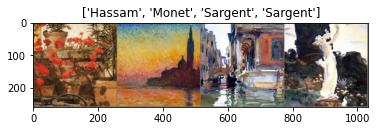

In [44]:
def imshow(inp, title = None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
# Get a batch of training data
inputs, classes = next(iter(dataloaders['training']))

# Make a grid from batch

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [45]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['training','validation']:
            if phase == 'training':
                model.train() # Set model to training mode
            else:
                model.eval() # Set model to evaluate mode
                
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase=='training'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'training':
                        loss.backward()
                        optimizer.step()
                        
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'training':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            #deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
        
    time_elapsed = time.time() - since
    print("Training complete in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
    print("Best val Acc: {:4f}".format(best_acc))
    
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [46]:
def visualize_model(model, num_images = 6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title("predicted: {}".format(class_names[preds[j]]))
                imshow(inputs.cpu(). data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

This model uses two convolution layers with a single fully connected layer.  The first convolution increases the channels to 16 and reduces the size to 256

In [47]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
     
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        # Fully connected 1
        self.fc1 = nn.Linear(32 * 62 * 62, 10) 
    
    def forward(self, x):
        # Set 1
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        
        # Set 2
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        
        try:
            #Flatten
            out = out.view(out.size(0), -1)
        except:
            print(out.size())
        #Dense
        out = self.fc1(out)
        
        return out


In [48]:
model_ft = CNNModel()
num_ftrs = 10

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [49]:
torch.cuda.list_gpu_processes()

'GPU:0\nprocess       3864 uses     2351.000 MB GPU memory\nprocess      13662 uses     1407.000 MB GPU memory'

In [50]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
training Loss: 2.1857 Acc: 0.2051
validation Loss: 2.0988 Acc: 0.2586

Epoch 1/24
----------
training Loss: 2.0756 Acc: 0.2570
validation Loss: 1.9873 Acc: 0.2899

Epoch 2/24
----------
training Loss: 2.0189 Acc: 0.2871
validation Loss: 1.9971 Acc: 0.2960

Epoch 3/24
----------
training Loss: 1.9814 Acc: 0.2996
validation Loss: 1.8778 Acc: 0.3515

Epoch 4/24
----------
training Loss: 1.9370 Acc: 0.3172
validation Loss: 1.8326 Acc: 0.3798

Epoch 5/24
----------
training Loss: 1.8990 Acc: 0.3390
validation Loss: 1.7927 Acc: 0.3990

Epoch 6/24
----------
training Loss: 1.8594 Acc: 0.3541
validation Loss: 1.8496 Acc: 0.3727

Epoch 7/24
----------
training Loss: 1.7326 Acc: 0.3959
validation Loss: 1.7029 Acc: 0.4253

Epoch 8/24
----------
training Loss: 1.7065 Acc: 0.3984
validation Loss: 1.6544 Acc: 0.4354

Epoch 9/24
----------
training Loss: 1.6919 Acc: 0.4067
validation Loss: 1.6526 Acc: 0.4242

Epoch 10/24
----------
training Loss: 1.6742 Acc: 0.4230
validation Lo

In [3]:
import torch.nn.functional as F

In [ ]:
F.batch_norm